In [2]:
import math
import numpy as np 
import shutil

from torchvision.models.resnet import *
import torchvision
import torch

import matplotlib
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import hog

import pandas as pd
from split_image import split_image
from scipy.spatial import distance
import json


#load dataset
dataset = torchvision.datasets.Caltech101("../CSE515-Project3/")
labels_caltech101 = np.array([dataset[i][1] for i in range(len(dataset))])
downdata_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=8)
label_name_to_idx = {name: idx for idx, name in enumerate(dataset.categories)}
print(len(dataset))
print(len(labels_caltech101))


8677
8677


Task 2: 

for each unique label l, computes the correspending c most significant clusters associated with the even numbered
Caltec101 images (using DBScan algorithm); the resulting clusters should be visualized both
- as differently colored point clouds in a 2-dimensional MDS space, and
- as groups of image thumbnails.


and
- for the odd numbered images, predicts the most likely labels using the c label-specific clusters.

The system should also output per-label precision, recall, and F1-score values as well as output an overall accuracy value.

1. Calculate clusters for labels using even numbered images using DBScan

Distance Metric: Cosine Distance

In [3]:
def compare_features(query_features, database_features):
    dot_product = np.dot(query_features, database_features)
    norm_a = np.linalg.norm(query_features)
    norm_b = np.linalg.norm(database_features)
    similarity = dot_product / (norm_a * norm_b)
    return similarity

def get_label_key_for_id(id):
    return list(label_name_to_idx.keys())[list(label_name_to_idx.values()).index(id)]
#for i in range(1000):
#    print(compare_features(jsonData[0]['Weights'], jsonData[i]['Weights']))


In [5]:
# Extract class names from the Caltech101 dataset
import sqlite3
from skimage.color import rgb2gray
from torchvision import models, transforms
from PIL import Image


label_name_to_idx = {name: idx for idx, name in enumerate(dataset.categories)}
conn =   sqlite3.connect('image_features.db')
cursor = conn.cursor()

# Initialize the ResNet50 model
resnet50 = models.resnet50(pretrained=True)
resnet50.eval()

# Create table if it doesn't exist
cursor.execute('''
CREATE TABLE IF NOT EXISTS features (
    imageID INTEGER PRIMARY KEY,
    label TEXT,
    ColorMoments BLOB,
    HOG BLOB,
    AvgPool BLOB,
    Layer3 BLOB,
    FCLayer BLOB,
    RESNET BLOB
)
''')

def store_in_database(imageID, features):
    # Convert numpy arrays to bytes for storage
    n0_usage, label = dataset[imageID]
    # print("Size of ColorMoments before storing:", features['ColorMoments'].shape)
    ColorMoments_bytes = features['ColorMoments'].astype(np.float32).tobytes()
    # print("Size of ColorMoments before storing:", len(ColorMoments_bytes))

    HOG_bytes = features['HOG'].astype(np.float32).tobytes()

    # Reduce dimensionality of ResNet-AvgPool and ResNet-Layer3 features
    ResNetAvgPool1024 = np.array(features['AvgPool'])
    AvgPool_bytes = ResNetAvgPool1024.tobytes()
    ResNetLayer31024 = np.array(features['Layer3'])
    Layer3_bytes = ResNetLayer31024.tobytes()
    FCLayer_bytes = features['FCLayer'].tobytes()
    ResNetOutput_bytes = features['RESNET'].tobytes()

    # Check if imageID already exists in the database
    cursor.execute("SELECT 1 FROM features WHERE imageID=?", (imageID,))
    exists = cursor.fetchone()

    if not exists:
        # Insert a new record if imageID doesn't exist
        cursor.execute('''
        INSERT INTO features (imageID, label, ColorMoments, HOG, AvgPool, Layer3, FCLayer, RESNET)
        VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', (
            imageID, label, ColorMoments_bytes, HOG_bytes, AvgPool_bytes, Layer3_bytes, FCLayer_bytes, ResNetOutput_bytes))

        conn.commit()

def load_features_from_database():
    cursor.execute("SELECT imageID, label, ColorMoments, HOG, AvgPool, Layer3, FCLayer, RESNET FROM features")
    rows = cursor.fetchall()
    for row in rows:
        database.append({
            "imageID": row[0],
            "label": row[1],
            "features": {
                "ColorMoments": np.frombuffer(row[2], dtype=np.float32),
                "HOG": np.frombuffer(row[3], dtype=np.float32),
                "AvgPool": np.frombuffer(row[4], dtype=np.float32),
                "Layer3": np.frombuffer(row[5], dtype=np.float32),
                "FCLayer": np.frombuffer(row[6], dtype=np.float32),
                "RESNET": np.frombuffer(row[7], dtype=np.float32)
            }
        })

# Database simulation (in reality, you'd use an actual database)
database = []


def custom_transform(image):
    # Check if the image is grayscale
    if len(image.getbands()) == 1:
        # Convert grayscale to RGB by repeating the channel 3 times
        image = Image.merge("RGB", (image, image, image))
    return image


custom_transforms = transforms.Lambda(lambda x: custom_transform(x))

# Define transformations for the image
transform = transforms.Compose([
    custom_transforms,  # Use the custom transforms here
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def compute_cell_moments(image_np, start_row, end_row, start_col, end_col):
    cell_values = image_np[start_row:end_row, start_col:end_col]
    total_pixels = cell_values.shape[0] * cell_values.shape[1]

    # Compute mean for each channel
    mean = np.sum(cell_values, axis=(0, 1)) / total_pixels

    # Compute variance for each channel
    variance = np.sum((cell_values - mean) ** 2, axis=(0, 1)) / total_pixels

    # Compute standard deviation for each channel
    std_dev = np.sqrt(variance)

    return mean, std_dev, variance

def compute_color_moments_matrix(image_np):
    if len(image_np.shape) == 2:  # Grayscale image
        image_np = np.stack([image_np, image_np, image_np], axis=-1)  # Convert to RGB by repeating the channel 3 times

    height, width, channels = image_np.shape
    cell_height, cell_width = height // 10, width // 10

    mean_matrix = np.zeros((10, 10, channels))
    std_dev_matrix = np.zeros((10, 10, channels))
    variance_matrix = np.zeros((10, 10, channels))

    for i in range(10):
        for j in range(10):
            start_row, end_row = i * cell_height, (i + 1) * cell_height
            start_col, end_col = j * cell_width, (j + 1) * cell_width
            mean, std_dev, variance = compute_cell_moments(image_np, start_row, end_row, start_col, end_col)
            mean_matrix[i, j] = mean
            std_dev_matrix[i, j] = std_dev
            variance_matrix[i, j] = variance

    return mean_matrix, std_dev_matrix, variance_matrix


def extract_features(image):
    # Extract color moments manually
    image_np_resized = np.array(image.resize((100, 100)))
    mean_matrix, std_dev_matrix, variance_matrix = compute_color_moments_matrix(image_np_resized)
    color_moments = np.concatenate([mean_matrix, std_dev_matrix, variance_matrix], axis=2).flatten()
    # print("ColorMoments shape:", color_moments.shape)

    # Convert image to grayscale for HOG
    image_tensor = transform(image)  # Use the main transform here
    gray_image = rgb2gray(image_tensor.permute(1, 2, 0).numpy())

    # Extract HOG features
    hog_features = hog(gray_image, pixels_per_cell=(16, 16), cells_per_block=(4, 4), visualize=False)
    hog_features = hog_features.flatten()[:900]

    outputs = {}

    def hook(module, input, output):
        outputs[module._get_name()] = output

    # Attach hooks to the desired layers
    hook_handles = []
    hook_handles.append(resnet50.avgpool.register_forward_hook(hook))
    hook_handles.append(resnet50.layer3.register_forward_hook(hook))
    hook_handles.append(resnet50.fc.register_forward_hook(hook))

    # Extract features using RESNET50
    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        resnet_output = resnet50(image_tensor)

    # Remove hooks
    for handle in hook_handles:
        handle.remove()

    avgpool_output = outputs['AdaptiveAvgPool2d'].squeeze().numpy()
    avgpool_1024 = (avgpool_output[::2] + avgpool_output[1::2]) / 2

    layer3_output = outputs['Sequential'].squeeze().numpy()
    layer3_output_flattened = layer3_output.reshape(-1)
    stride = len(layer3_output_flattened) // 1024
    layer3_1024 = [np.mean(layer3_output_flattened[i:i + stride]) for i in
                   range(0, len(layer3_output_flattened), stride)]

    fc_1000 = outputs['Linear'].squeeze().numpy()
    resnet = resnet_output.squeeze().numpy()

    return {
        "ColorMoments": color_moments,
        "HOG": hog_features,
        "AvgPool": avgpool_1024,
        "Layer3": layer3_1024,
        "FCLayer": fc_1000,
        "RESNET": resnet
    }


def task_0a():
    for i, (image, label) in enumerate(dataset):
        # Only process even-numbered images
        if i % 2 == 0:
            features = extract_features(image)
            #if i % 500 == 0:
            #    print(i)
            # Store features in the database
            store_in_database(i, features)

#task_0a()
#load_features_from_database()
#print(database)

def extractOddFeatures():
    for i, (image, label) in enumerate(dataset):
        # Only process even-numbered images
        if i % 2 == 1:
            features = extract_features(image)
            #if i % 500 == 0:
            #    print(i)
            # Store features in the database
            store_in_database(i, features)

#extractOddFeatures()

In [4]:
#get FC matrix for each label
def getFeatureMatrixDictForLabels():
    labelDataMatrix = {}
    for i in range(101):
        # Get the image IDs for the given label from the database
        cursor.execute("SELECT imageID FROM features WHERE label=?", (i,))
        image_ids_for_label = [row[0] for row in cursor.fetchall()]
        
        cursor.execute("SELECT FCLayer FROM features WHERE imageID=?", (image_ids_for_label[0],))
        image_weights = np.frombuffer(cursor.fetchone()[0], dtype=np.float32)
        matrix = image_weights

        for j in range(1, len(image_ids_for_label)):
            cursor.execute("SELECT FCLayer FROM features WHERE imageID=?", (image_ids_for_label[j],))
            image_weights = np.frombuffer(cursor.fetchone()[0], dtype=np.float32)
            matrix = np.vstack([matrix, image_weights])
        
        #print(matrix)
        labelDataMatrix[str(i)] = matrix

    return labelDataMatrix

#get image-label feature matrix for chosen input latent semantic file
def getFeatureMatrixDictForLabelsJSON(latent_semantics_file):
    labelDataMatrix = {}

    with open(f"{latent_semantics_file}.json", 'r') as f:
        latent_semantics_data = json.load(f)

    for i in range(101):
        # Get the image IDs for the given label from the database
        cursor.execute("SELECT imageID FROM features WHERE label=?", (i,))
        image_ids_for_label = [row[0] for row in cursor.fetchall()]
        #print(image_ids_for_label)

        matrix = next((x['Weights'] for x in latent_semantics_data if x['ImageID'] == image_ids_for_label[0]), None)
        #cursor.execute("SELECT FCLayer FROM features WHERE imageID=?", (image_ids_for_label[0],))
        #image_weights = np.frombuffer(cursor.fetchone()[0], dtype=np.float32)
        #matrix = image_weights

        for j in range(1, len(image_ids_for_label)):
            image_weights = next((x['Weights'] for x in latent_semantics_data if x['ImageID'] == image_ids_for_label[j]), None)
            matrix = np.vstack([matrix, image_weights])
        
        #print(matrix)
        labelDataMatrix[str(i)] = matrix

    return labelDataMatrix

#labelMatrixDictJSON = getFeatureMatrixDictForLabelsJSON("T3-RESNET-5-LDA")
#labelMatrixDict = getFeatureMatrixDictForLabels()

In [7]:
#get FC matrix for each label
from math import ceil


def getFCMatrixForEvenID():
    cursor.execute("SELECT FCLayer FROM features WHERE imageID=?", (0,))
    dataMatrix = np.frombuffer(cursor.fetchone()[0], dtype=np.float32)

    for i in range(1,int(ceil(len(dataset)/2))):
        cursor.execute("SELECT FCLayer FROM features WHERE imageID=?", (2*i,))
        image_weights = np.frombuffer(cursor.fetchone()[0], dtype=np.float32)
        dataMatrix = np.vstack([dataMatrix, image_weights])

    return dataMatrix

#get image-label feature matrix for chosen input latent semantic file
def getLatentSemanticsMatrixForEvenID(latent_semantics_file):
    with open(f"{latent_semantics_file}.json", 'r') as f:
        latent_semantics_data = json.load(f)

    dataMatrix = latent_semantics_data[0]['Weights']

    for i in range(1, len(latent_semantics_data)):
        image_weights = next((x['Weights'] for x in latent_semantics_data if x['ImageID'] == latent_semantics_data[i]['ImageID']), None)
        dataMatrix = np.vstack([dataMatrix, image_weights])

    return dataMatrix

FCEvenData = getFCMatrixForEvenID()
#LSEvenData = getLatentSemanticsMatrixForEvenID("T3-RESNET-5-LDA")

In [491]:
torch.save(FCEvenData, "FCEvenData.pt")

In [8]:
def getFCMatrixForOddID():
    cursor.execute("SELECT FCLayer FROM features WHERE imageID=?", (1,))
    dataMatrix = np.frombuffer(cursor.fetchone()[0], dtype=np.float32)

    for i in range(3,len(dataset)):
        if i%2 == 1:
            cursor.execute("SELECT FCLayer FROM features WHERE imageID=?", (i,))
            image_weights = np.frombuffer(cursor.fetchone()[0], dtype=np.float32)
            dataMatrix = np.vstack([dataMatrix, image_weights])

    return dataMatrix

FCOddData = getFCMatrixForOddID()
print(FCOddData.shape)

(4338, 1000)


In [9]:
torch.save(FCOddData, "FCOddData.pt")

In [10]:
#Even ID label
evenImageLabelList = []
for i in range(int(ceil(len(labels_caltech101)/2))):
    evenImageLabelList.append(labels_caltech101[2*i])
print(len(evenImageLabelList))

4339


In [11]:
from sklearn.datasets import load_digits
from sklearn.manifold import MDS
from scipy.spatial.distance import directed_hausdorff

import seaborn as sns         
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import sklearn.datasets as dt
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances

def computeDissimilarityMatrix(data):
    matrix = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        for j in range(len(data)):
            matrix[i][j] = directed_hausdorff([data[i]], [data[j]])[0]
            #matrix[i][j] = compare_features(data[i], data[j])
    return matrix


In [28]:
FCdissimilarityMatrix = computeDissimilarityMatrix(FCEvenData)
#LSdissimilarityMatrix = computeDissimilarityMatrix(LSEvenData)
#print(LSdissimilarityMatrix.shape)
print(FCdissimilarityMatrix.shape)

(4339, 4339)
(4339, 4339)


In [29]:
torch.save(FCdissimilarityMatrix, "./FCdissimilarityMatrix.pt")
#torch.save(LSdissimilarityMatrix, "./T2LDAdissimilarityMatrix.pt")


In [12]:
#load precalculated data
FCdissimilarityMatrix = torch.load("./FCdissimilarityMatrix.pt")
#LSdissimilarityMatrix = torch.load("./T2LDAdissimilarityMatrix.pt")

In [13]:
def calculatePlotMDS(dm, X, y):
    embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
    X_transformed = embedding.fit_transform(dm)
    
    return X_transformed

#fcMDS = calculatePlotMDS(FCdissimilarityMatrix, FCEvenData, evenImageLabelList)
#torch.save(fcMDS, "./fcMDS.pt")
#ldaMDS = calculatePlotMDS(LSdissimilarityMatrix, LSEvenData, calculatePlotMDS)
#torch.save(ldaMDS, "./ldaMDS.pt")

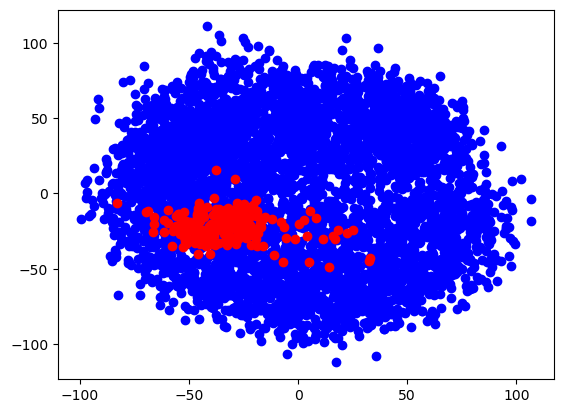

In [14]:
fcMDS = torch.load("./fcMDS.pt")
plt.scatter(fcMDS[218:len(fcMDS),0], fcMDS[218:len(fcMDS),1], color = "blue") 
plt.scatter(fcMDS[0:217,0], fcMDS[0:217,1], color = "red") 

In [15]:
def getLabelIndex(id):
    for i in range(len(evenImageLabelList)):
        if evenImageLabelList[i] == id:
            print(i)

getLabelIndex(5)

962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099
1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115
1116
1117
1118
1119
1120
1121
1122
1123
1124
1125
1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137
1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149
1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164
1165
1166
1167
1168
116

In [ ]:
def normalizeCoordinates(D):
    xMin = D.min(axis=0)[0]
    yMin = D.min(axis=0)[1]

    xMax = D.max(axis=0)[0]
    yMax = D.max(axis=0)[1]

    matrix = D
    for i in range(matrix.shape[0]):
        matrix[i][0] = (matrix[i][0] - xMin)/(xMax-xMin)
        matrix[i][1] = (matrix[i][1] - yMin)/(yMax-yMin)
    return matrix

normalizedFCMDS = normalizeCoordinates(fcMDS)
print(normalizedFCMDS.shape)
plt.scatter(normalizedFCMDS[218:,0], normalizedFCMDS[218:,1], color = "blue") 
plt.scatter(normalizedFCMDS[0:217,0], normalizedFCMDS[0:217,1], color = "red") 

In [16]:
def dbScan(D, eps, MinPts, corePoints):
    labels = [0]*len(D)

    # C is the ID of the current cluster.    
    C = 0
    
    # For each point P in the Dataset D...
    # ('P' is the index of the datapoint, rather than the datapoint itself.)
    for P in range(0, len(D)):
        print("Point " + str(P))
        #print(labels)
    
        # Only points that have not already been claimed can be picked as new 
        # seed points.    
        # If the point's label is not 0, continue to the next point.
        if not (labels[P] == 0):
           continue
        
        # Find all of P's neighboring points.
        NeighborPts = region_query(D, P, eps)
    
        
        #print(len(NeighborPts))
        if len(NeighborPts) < MinPts:
            labels[P] = -1
        # Otherwise, if there are at least MinPts nearby, use this point as the 
        # seed for a new cluster.    
        else: 
           C += 1
           grow_cluster(D, labels, P, NeighborPts, C, eps, MinPts)
    
    # All data has been clustered!
    return labels


def grow_cluster(D, labels, P, NeighborPts, C, eps, MinPts):
    # Assign the cluster label to the seed point.
    labels[P] = C
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
       
        if labels[Pn] == -1:
           labels[Pn] = C
        
        # Otherwise, if Pn isn't already claimed, claim it as part of C.
        elif labels[Pn] == 0:
            # Add Pn to cluster C (Assign cluster label C).
            labels[Pn] = C
            
            # Find all the neighbors of Pn
            PnNeighborPts = region_query(D, Pn, eps)

            #print(len(PnNeighborPts))
            if len(PnNeighborPts) >= MinPts:
                #NeighborPts = NeighborPts + PnNeighborPts
                NeighborPts = list(set(NeighborPts) | set(PnNeighborPts))
                #print(NeighborPts)         
        
        # Advance to the next point in the FIFO queue.
        i += 1        
    
    # We've finished growing cluster C!


def region_query(D, P, eps):
    '''
    Find all points in dataset `D` within distance `eps` of point `P`.
    '''
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        #dist = np.dot(np.squeeze(D[P]), np.squeeze(D[Pn]))/np.linalg.norm(D[P] * D[Pn])
        #dist = np.linalg.norm(D[P] - D[Pn])
        similarity = compare_features(D[P], D[Pn])
        
        #print("P = " + str(P))
        #print("Pn = " + str(Pn))
        #print(similarity)
        # If the distance is below the threshold, add it to the neighbors list.
        #if np.linalg.norm(D[P] - D[Pn]) < eps:
        #if dist < eps:
        if similarity > eps:
           #print(np.linalg.norm(D[P] - D[Pn]))
           neighbors.append(Pn)
            
    return neighbors


#dbscan = dbScan(FCEvenData, 40, 15, [])

dbscan = dbScan(FCEvenData, 0.8, 10, [])

In [ ]:
fig = plt.figure(2, (15,6))
ax = fig.add_subplot(1,2,1)    
ax = sns.scatterplot(x=fcMDS[:, 0], y=fcMDS[:, 1],
                        #hue=clustering.labels_, palette=['r', 'g', 'b', 'c'])
                        hue=dbscan, palette=sns.color_palette("tab10"))

In [ ]:
for i in dbscan:
    print(i)

In [293]:
count = 0
for i in dbscan:
    if i == -1:
        count += 1

print(count)

1984


In [17]:
def calculateCorePoints(D, labels):
    i = 0
    corePoints = []
    for label in range(101):
        sum = np.zeros((1000))
        count = 0
        while i < len(labels) and labels[i] == label:
            sum += D[i]
            i+=1
            count +=1
        corePoints.append(sum/count)
    return corePoints

corePointsFC = calculateCorePoints(FCEvenData, evenImageLabelList)
print(len(corePointsFC))
torch.save(corePointsFC, "T2corePoints.pt")

101


In [18]:
def getCorePoints(D, labels):
    points = np.array([D[0]])
    j = 1
    for i in range(1, len(D)):
        if j == labels[i] and points.shape[0] <= j:
            points = np.vstack((points, D[i]))
            j += 1
            print(i)
    return points

fcCorePoints = getCorePoints(FCEvenData, evenImageLabelList)
#print(fcCorePoints)

218
435
535
934
962
1362
1383
1404
1427
1454
1477
1494
1558
1607
1628
1671
1716
1741
1763
1824
1848
1877
1908
1962
1985
2020
2056
2091
2116
2142
2170
2204
2230
2262
2296
2334
2366
2392
2424
2467
2500
2534
2556
2573
2590
2616
2665
2715
2736
2763
2807
2847
2863
2895
2938
2995
3025
3066
3105
3125
3158
3180
3200
3243
3259
3297
3325
3342
3362
3385
3404
3427
3453
3470
3499
3540
3569
3594
3614
3645
3665
3707
3735
3753
3785
3807
3850
3880
3912
3929
3972
3996
4039
4077
4196
4215
4244
4261
4289
4309


In [ ]:
def dbscanForLabel(D, eps, MinPts, corePoints):
    clusters = []
    C = 0

    #start at corePoint
    for corepoint in corePoints:
        clusters.append([])
        NeighborPts = region_query_for_corePoint(D, corepoint, eps)
        grow_cluster_for_corepoints(D, clusters, corepoint, NeighborPts, C, eps, MinPts)
        C += 1
    
    return clusters


def grow_cluster_for_corepoints(D, clusters, P, NeighborPts, C, eps, MinPts):
    # Assign the cluster label to the seed point.
    #clusters[C] = NeighborPts
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
        clusters[C].append(NeighborPts[i])
       
        PnNeighborPts = region_query(D, Pn, eps)

        #print(len(PnNeighborPts))
        if len(PnNeighborPts) >= MinPts:
            #NeighborPts = NeighborPts + PnNeighborPts
            NeighborPts = list(set(NeighborPts) | set(PnNeighborPts))      
        
        # Advance to the next point in the FIFO queue.
        i += 1        



def region_query_for_corePoint(D, corePoint, eps):
    '''
    Find all points in dataset `D` within distance `eps` of point `P`.
    '''
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        #dist = np.dot(np.squeeze(D[P]), np.squeeze(D[Pn]))/np.linalg.norm(D[P] * D[Pn])
        #dist = np.linalg.norm(D[P] - D[Pn])
        similarity = compare_features(corePoint, D[Pn])
        
        #print("P = " + str(P))
        #print("Pn = " + str(Pn))
        #print(similarity)
        # If the distance is below the threshold, add it to the neighbors list.
        #if np.linalg.norm(D[P] - D[Pn]) < eps:
        #if dist < eps:
        if similarity > eps:
           #print(np.linalg.norm(D[P] - D[Pn]))
           neighbors.append(Pn)
            
    return neighbors

clusters = dbscanForLabel(FCEvenData, 0.8, 10, fcCorePoints)
clustersCalculated = dbscanForLabel(FCEvenData, 0.8, 10, corePointsFC)


In [62]:
def dbscanForLabel(D, eps, MinPts, corePoints, labelList):
    clusters = []
    C = 0
    #start at corePoint
    for corepoint in corePoints:
        clusters.append([])
        NeighborPts = region_query_for_corePoint(D, corepoint, eps)
        grow_cluster_for_corepoints(D, clusters, corepoint, NeighborPts, C, eps, MinPts, labelList)
        C += 1
    
    return clusters


def grow_cluster_for_corepoints(D, clusters, P, NeighborPts, C, eps, MinPts, labelList):
    # Assign the cluster label to the seed point.
    #clusters[C] = NeighborPts
    i = 0
    while i < len(NeighborPts):    
        
        # Get the next point from the queue.        
        Pn = NeighborPts[i]
        clusters[C].append(NeighborPts[i])
       
        PnNeighborPts = region_query(D, Pn, eps)

        #print(len(PnNeighborPts))
        if len(PnNeighborPts) >= MinPts:
            #NeighborPts = NeighborPts + PnNeighborPts
            NeighborPts = NeighborPts + list(set(PnNeighborPts) - set(NeighborPts))      
        else:
            NeighborPts = NeighborPts + list(set(relax_dbscan(C, labelList)) - set(NeighborPts))   
        # Advance to the next point in the FIFO queue.
        i += 1        


def relax_dbscan(label, labelList):
    #relax dbscan add more neighbor points to query by
    points = []
    for i in range(len(labelList)):
        if labelList[i] == label and len(points) < 10:
            points.append(i)
    return points  

def region_query_for_corePoint(D, corePoint, eps):
    '''
    Find all points in dataset `D` within distance `eps` of point `P`.
    '''
    neighbors = []
    
    # For each point in the dataset...
    for Pn in range(0, len(D)):
        #dist = np.dot(np.squeeze(D[P]), np.squeeze(D[Pn]))/np.linalg.norm(D[P] * D[Pn])
        #dist = np.linalg.norm(D[P] - D[Pn])
        similarity = compare_features(corePoint, D[Pn])
        
        #print("P = " + str(P))
        #print("Pn = " + str(Pn))
        #print(similarity)
        # If the distance is below the threshold, add it to the neighbors list.
        #if np.linalg.norm(D[P] - D[Pn]) < eps:
        #if dist < eps:
        if similarity > eps:
           #print(np.linalg.norm(D[P] - D[Pn]))
           neighbors.append(Pn)
            
    return neighbors

relaxed_fcCluster_calculated = dbscanForLabel(FCEvenData, 0.8, 10, corePointsFC, evenImageLabelList)

In [68]:
torch.save(relaxed_fcCluster_calculated, "fcClusters_Calculated.pt")

In [63]:
for i in relaxed_fcCluster_calculated:
    print(i)

[0, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 40, 41, 43, 44, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146, 147, 154, 155, 158, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 216, 217, 220, 221, 222, 223, 224, 226, 228, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 247, 248, 250, 227, 103, 153, 234, 46, 119, 249, 218, 105, 131,

In [ ]:
from numpy import asarray

def plotClusters(points, labels, title):
    '''
    points = list of 2D MDS points

    '''
    fig = plt.figure(2, (15,6))
    ax = fig.add_subplot(1,2,1)    
    ax = sns.scatterplot(x=points[:, 0], y=points[:, 1],
                         hue=labels, palette=sns.color_palette("tab10"))
    plt.title(title)    
    plt.show()

def getCoordinateList(indexList, coordinateList):
    pointList = coordinateList[indexList[0]]
    for i in range(1, len(indexList)):
        pointList = np.vstack((pointList, coordinateList[indexList[i]]))
    return pointList

def getPlotLabelList(clusterList):
    labelList = []
    j = 0
    for i in clusterList:
        labelList = labelList + [j]*len(i)
        j += 1
    return labelList

def getClusterCoordinateList(clusterList, coordinateList):
    result = getCoordinateList(clusterList[0], coordinateList)
    for i in range(1, len(clusterList)):
        result = np.vstack((result ,getCoordinateList(clusterList[i], coordinateList)))
    return result

plotClusters(getClusterCoordinateList(relaxed_fcCluster_calculated, fcMDS), getPlotLabelList(relaxed_fcCluster_calculated), "FC")

In [444]:
print(label_name_to_idx)

{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch': 55, 'lamp': 56, 'laptop': 57, 'llama': 58, 'lobster': 59, 'lotus': 60, 'mandolin': 61, 'mayfly': 62, 'menorah': 63

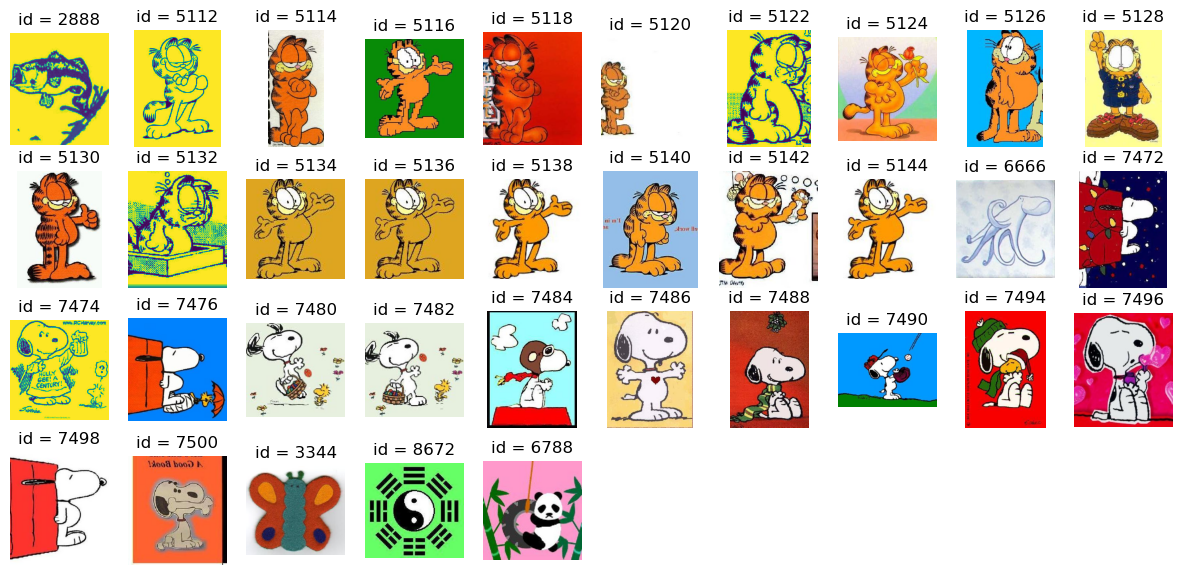

In [9]:
from math import ceil

relaxed_fcCluster_calculated = torch.load("./fcClusters_Calculated.pt")
def plotImageThumbnails(imageIDList):
    fig = plt.figure(figsize=(15, 2* ceil(len(imageIDList))/10))
    plt.axis('off')
    for i in range(len(imageIDList)):
        fig.add_subplot(ceil(len(imageIDList)/10), 10, i+1)
        im =  np.asarray(dataset[2*imageIDList[i]][0])
        plt.axis('off')
        plt.imshow(im)
        plt.title("id = " + str(2*imageIDList[i]))
plotImageThumbnails(relaxed_fcCluster_calculated[43])

In [18]:
relaxed_fcCluster_calculated = torch.load("./fcClusters_Calculated.pt")
relaxed_fcCluster_calculated[43] = relaxed_fcCluster_calculated[43][0:17]
relaxed_fcCluster_calculated[83] = relaxed_fcCluster_calculated[83][16:]
print(relaxed_fcCluster_calculated[83])
print(relaxed_fcCluster_calculated[43])
#relaxed_fcCluster_calculated[43] = relaxed_fcCluster_calculated[43][0:17]

[3333, 3394, 3735, 3736, 3737, 3738, 3740, 3741, 3742, 3743, 3744, 3745, 3747, 3748, 3749, 3750, 3752, 4336, 3739, 2570, 2564]
[1444, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570, 2571]


In [19]:
torch.save(relaxed_fcCluster_calculated, "fcClusters_Calculated.pt")

2. Calculate precision, recall, F1 score and overall accuracy

In [64]:
def getLabelList(labelIndexList, label):
    result = []
    for i in range(len(labelIndexList)):
        if labelIndexList[i] == label:
            result.append(i)
    return result

def calculateLabelPrecision(label, cluster, labelIndexList):
    #true postives/(true postitives + false positives)
    labelList = getLabelList(labelIndexList, label)
    truePositives = list(set(labelList) & set(cluster))
    precision = len(truePositives)/len(cluster)
    return precision

overallprecisionCalc = 0
for i in range(101):
    #print("label " + str(i) + ": " + str(calculateLabelPrecision(i, clustersCalculated[i], evenImageLabelList)))
    #if calculateLabelPrecision(i, clustersCalculated[i], evenImageLabelList) < 0.8:
    #    print(i)
    overallprecisionCalc += calculateLabelPrecision(i, relaxed_fcCluster_calculated[i], evenImageLabelList)
print(overallprecisionCalc/101)

0.7953212386421413


In [66]:
def calculateLabelRecall(label, cluster, labelIndexList):
    #true postives/(true postitives + false positives)
    labelList = getLabelList(labelIndexList, label)
    truePositives = list(set(labelList) & set(cluster))
    falseNegatives = list(set(labelList) - set(cluster))
    recall = len(truePositives)/(len(truePositives) + len(falseNegatives))
    return recall

overallRecall = 0
for i in range(101):
    #print("label " + str(i) + ": " + str(calculateLabelPrecision(i, clustersCalculated[i], evenImageLabelList)))
    #if calculateLabelPrecision(i, clustersCalculated[i], evenImageLabelList) < 0.8:
    #    print(i)
    overallRecall += calculateLabelRecall(i, relaxed_fcCluster_calculated[i], evenImageLabelList)
print(overallRecall/101)

0.7495245761862721


In [85]:
def calculateF1Score(label, cluster, labelIndexList):
    prec = calculateLabelPrecision(label, cluster, labelIndexList)
    recall = calculateLabelRecall(label, cluster, labelIndexList)
    if (prec + recall) != 0:
        f1Score = 2 * (prec*recall)/(prec+recall)
    else:
        f1Score = 0
    return f1Score

In [67]:
def calcuateLabelAccuracy(label, cluster, labelIndexList):
    #number of correct predictions / size of dataset
    labelList = getLabelList(labelIndexList, label)
    truePositives = list(set(labelList) & set(cluster))
    falseNegatives = list(set(labelList) - set(cluster))
    falsePositives = list(set(cluster) - set(labelList))
    numTrueNegatives = len(labelIndexList) - len(truePositives) - len(falseNegatives) - len(falsePositives)
    accuracy = (len(truePositives) + numTrueNegatives)/ len(labelIndexList)
    return accuracy

overallaccCalc = 0
for i in range(101):
    #print("label " + str(i) + ": " + str(calculateLabelPrecision(i, clustersCalculated[i], evenImageLabelList)))
    #if calculateLabelPrecision(i, clustersCalculated[i], evenImageLabelList) < 0.8:
    #    print(i)
    overallaccCalc += calcuateLabelAccuracy(i, relaxed_fcCluster_calculated[i], evenImageLabelList)
print(overallaccCalc/101)

0.9896974025588781


5 most relevant clusters:

Cluster: 1
[2858, 2864, 2866, 2868, 2872, 2884, 2886, 2890, 2892, 2894, 2896, 2898, 2900, 2904, 2854, 2856, 2860, 2862, 2870]
Accuracy: 0.9981562572021203
Precision: 1.0
Recall: 0.7037037037037037
F1 Score: 0.8260869565217391

Cluster: 2
[4460, 4462, 4466, 4470, 4476, 4478, 4486, 4488, 4490, 4510, 4514, 4520, 4464, 4468, 4472, 4474]
Accuracy: 0.9900898824613966
Precision: 0.0
Recall: 0.0
F1 Score: 0

Cluster: 3
[5330, 5332, 5336, 5340, 5344, 5346, 5348, 5356, 5360, 5364, 5366, 5370, 5372, 5374, 5376, 5380, 5382, 5384, 5386, 5390, 5392, 5396, 5398, 5400, 5402, 5408, 5410, 5412, 5414, 5416, 5418, 5420, 5422, 5424, 5428, 5354, 5334, 5338, 5342, 5388]
Accuracy: 0.9845586540677576
Precision: 0.0
Recall: 0.0
F1 Score: 0

Cluster: 4
[4182, 4188, 4190, 4194, 4196, 4200, 4206, 4210, 4212, 4218, 4222, 4224, 4226, 4232, 4236, 4242, 4256, 4262, 4268, 4270, 4280, 4192, 4198, 4184, 4186]
Accuracy: 0.988015671813782
Precision: 0.0
Recall: 0.0
F1 Score: 0

Cluster: 5
[6906, 

C:\Users\xinhw\AppData\Local\Temp\ipykernel_34024\1955729065.py:10: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.scatterplot(x=points[:, 0], y=points[:, 1],


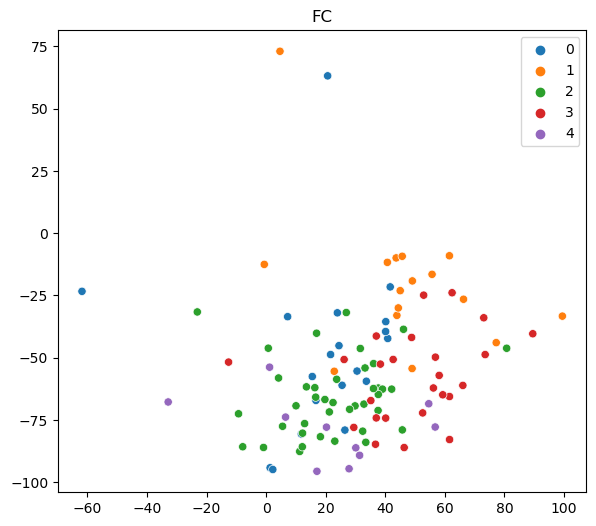

In [128]:
#c = input("Please enter the number of clusters")
#l = input ("Please enter the label you would like to find relevant clusters for")

def computeRelevantClusters(c, label):
    data = torch.load("./FCEvenData.pt")
    #Even ID label
    evenImageLabelList = []
    for i in range(int(ceil(len(labels_caltech101)/2))):
        evenImageLabelList.append(labels_caltech101[2*i])
    #print(len(evenImageLabelList))

    clusters = torch.load("./fcClusters_Calculated.pt")
    corePoints = torch.load("./T2corePoints.pt")

    dist = {}
    #initial core point for that label
    for i in range(len(corePoints)):
        dist.update({i: compare_features(corePoints[i], corePoints[label])})

    sortedDict = dict(sorted(dist.items(), key=lambda item: item[1]))
    
    queryPts = []
    idx = 0
    while len(queryPts) < c:
        queryPts.append(list(sortedDict)[len(corePoints)-1-idx])
        idx += 1



    c_clusters = []
    for i in range(0, c):
        c_clusters.append(clusters[queryPts[i]])
    
    return c_clusters 

def getClusterLabel(cluster):
    clusters = torch.load("./fcClusters_Calculated.pt")
    i = 0
    for clust in clusters:
        if cluster == clust:
            return i
        i += 1


c = 5
l = 1   
clusters = computeRelevantClusters(5, 9)

#need to have labels_caltech101
def task_2a(c, l):
    evenImageLabelList = []
    for i in range(int(ceil(len(labels_caltech101)/2))):
        evenImageLabelList.append(labels_caltech101[2*i])
    
    clusters = computeRelevantClusters(c, l)
    print(str(c) + " most relevant clusters:")
    i = 0
    for clust in clusters:
        i += 1
        print("\nCluster: " + str(i))
        print([x * 2 for x in clust])
        print("Accuracy: " + str(calcuateLabelAccuracy(l, clust, evenImageLabelList)))
        print("Precision: " + str(calculateLabelPrecision(l, clust, evenImageLabelList)))
        print("Recall: " + str(calculateLabelRecall(l, clust, evenImageLabelList)))
        print("F1 Score: " + str(calculateF1Score(l, clust, evenImageLabelList)))
    
    fcMDS = torch.load("./fcMDS.pt")
    plotClusters(getClusterCoordinateList(clusters, fcMDS), getPlotLabelList(clusters), "FC")

def task_2b(id, c):
    if id%2 == 0: 
        print("Please enter an even ID")
    else:
        clusters = computeRelevantClusters(c, labels_caltech101[id])
        i = 0
        print(str(c) + " most relevant labels for image id = " + str(id))
        for clust in clusters:
            i += 1
            label = getClusterLabel(clust)
            print(str(i) + ". " + list(label_name_to_idx.keys())[list(label_name_to_idx.values()).index(label)])

task_2a(5, 9)

#task_2b(3, 5)

In [119]:
def computeDissimilarityMatrix(data):
    matrix = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        for j in range(len(data)):
            matrix[i][j] = directed_hausdorff([data[i]], [data[j]])[0]
            #matrix[i][j] = compare_features(data[i], data[j])
    return matrix

def calculateMDSPlot(D, c):
    dataIndex = list(set([item for sublist in c for item in sublist]))
    #print(dataIndex)
    data = D[dataIndex[0]]
    print(len(dataIndex))
    for i in range(1, len(dataIndex)):
        data = np.vstack((data, D[dataIndex[i]]))
    print(data.shape)
    dMatrix = computeDissimilarityMatrix(data)

    embedding = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
    X_transformed = embedding.fit_transform(dMatrix)
    
    return X_transformed
    

clustMDS = calculateMDSPlot(FCEvenData, clusters)


110
(110, 1000)


c:\Users\xinhw\anaconda3\envs\cse515\lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


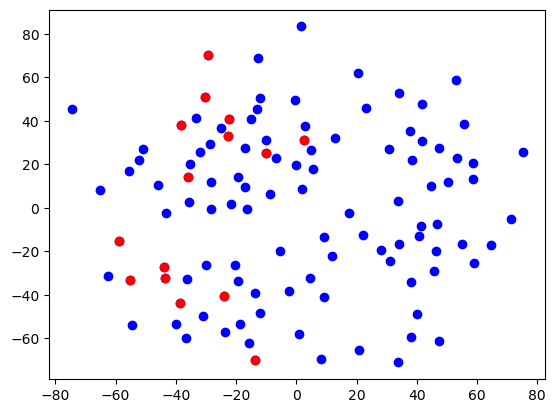

In [129]:
plt.scatter(clustMDS[:,0], clustMDS[:,1], color = "blue") 
plt.scatter(clustMDS[19:34,0], clustMDS[19:34,1], color = "red") 